In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForMaskedLM
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import logging
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
import json
import datetime
from typing import Dict, List
import warnings
#from google.colab import drive
torch.cuda.empty_cache()

CUDA_LAUNCH_BLOCKING=1

#drive.mount('/content/drive')
warnings.filterwarnings("ignore")

/Users/perrineqhn/Desktop/M2/S1/Documents_Structure/Projet/Artificial_Learner/artificial_learner/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Classe C4200MDataset
Cette classe est une sous-classe de Dataset de PyTorch et est utilisée pour préparer un ensemble de données destiné à entraîner un modèle BERT à générer des erreurs à partir de textes corrects.

Fonctionnalités principales :
- Initialisation (__init__) :

    - Paramètres :

        - clean_texts : liste des textes corrects qui serviront d'entrées au modèle.
        - error_texts : liste des textes contenant des erreurs correspondants aux textes corrects.
        - tokenizer : tokenizer BERT utilisé pour convertir les textes en tokens.
        - max_length : longueur maximale des séquences après tokenisation (par défaut 512).

    - Processus :

        - Stocke les textes corrects et les textes avec erreurs.
        - Initialise le tokenizer et la longueur maximale.

- Méthode __len__ :
    - Retourne le nombre total d'échantillons dans le jeu de données, basé sur la longueur de la liste des textes corrects.

- Méthode __getitem__ :
    - Paramètre :
        - idx : index de l'échantillon à récupérer.
    - Processus :

        - Récupère le texte correct et le texte avec erreurs à l'index spécifié.
        - Tokenisation du texte correct :
            - Utilise le tokenizer BERT pour convertir le texte en une séquence de tokens.
            - Applique un padding pour atteindre la max_length.
            - Tronque si le texte dépasse la longueur maximale.
            - Génère les tenseurs input_ids et attention_mask pour l'entrée du modèle.

        - Tokenisation du texte avec erreurs :
            - Même processus que pour le texte correct, mais sur le texte contenant des erreurs.
            - Les input_ids résultants serviront de labels lors de l'entraînement.

    - Retourne :
        - Un dictionnaire contenant :
            - 'input_ids' : les ids des tokens du texte correct (entrée du modèle).
            - 'attention_mask' : le masque d'attention indiquant les tokens à considérer.
            - 'labels' : les ids des tokens du texte avec erreurs (cible pour l'apprentissage).

In [2]:
class C4200MDataset(Dataset):
    def __init__(self, clean_texts: List[str], error_texts: List[str], tokenizer, max_length: int = 512):
        """
        Dataset pour le corpus C4200M qui apprend à générer des erreurs à partir de textes corrects
        Args:
            clean_texts: Liste des textes corrects (input)
            error_texts: Liste des textes avec erreurs (output/target)
            tokenizer: Tokenizer BERT
            max_length: Longueur maximale des séquences
        """
        self.clean_texts = clean_texts  # textes corrects comme input
        self.error_texts = error_texts  # textes avec erreurs comme cible
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.clean_texts)

    def __getitem__(self, idx):
        clean_text = self.clean_texts[idx]
        error_text = self.error_texts[idx]

        # Tokenisation du texte correct (input)
        clean_encoding = self.tokenizer(
            clean_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenisation du texte avec erreurs (target)
        error_encoding = self.tokenizer(
            error_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': clean_encoding['input_ids'].squeeze(),  # texte correct
            'attention_mask': clean_encoding['attention_mask'].squeeze(),
            'labels': error_encoding['input_ids'].squeeze()  # texte avec erreurs comme cible
        }

In [3]:
class TrainingTracker:
    """Classe pour suivre et enregistrer les métriques d'entraînement."""

    def __init__(self, output_dir: str):
        """
        Initialisation de la classe.

        Args:
            output_dir (str): Répertoire où les graphiques et l'historique seront sauvegardés.
        """
        self.output_dir = output_dir
        self.history = {
            'train_loss': [],  # Loss d'entraînement
            'val_loss': [],  # Loss de validation
            'train_acc': [],  # Précision d'entraînement
            'val_acc': []  # Précision de validation
        }
        os.makedirs(output_dir, exist_ok=True)
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    def add_epoch_metrics(self, train_loss, val_loss, train_acc, val_acc):
        """
        Ajoute les métriques d'une époque (entraînement et validation).

        Args:
            train_loss (float): Perte moyenne sur le jeu d'entraînement.
            val_loss (float): Perte moyenne sur le jeu de validation.
            train_acc (float): Précision sur le jeu d'entraînement.
            val_acc (float): Précision sur le jeu de validation.
        """
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_acc'].append(val_acc)

    def plot_metrics(self):
        """
        Affiche les courbes des métriques : précision et perte pour entraînement et validation.
        """
        import matplotlib.pyplot as plt

        epochs = range(1, len(self.history['train_acc']) + 1)

        # Courbe de précision
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_acc'], 'b', label='Training Accuracy')
        plt.plot(epochs, self.history['val_acc'], 'r', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Courbe de perte
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_loss'], 'b', label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], 'r', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_history(self):
        """
        Sauvegarde l'historique des métriques au format JSON.
        """
        # Chemin du fichier JSON
        history_path = os.path.join(self.output_dir, f'training_history_{self.timestamp}.json')

        # Écriture de l'historique dans le fichier
        with open(history_path, 'w') as f:
            json.dump(self.history, f, indent=4)  # Indente pour rendre le fichier lisible


In [4]:
def get_device():
    """
    Fonction pour sélectionner le device (CPU, CUDA, MPS) disponible.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

In [5]:
def calculate_accuracy(predictions, labels):
    """Calculer l'accuracy pour un batch"""
    pred_tokens = predictions.argmax(dim=-1)
    correct = (pred_tokens == labels) & (labels != -100)  # Ignorer les tokens paddés
    return correct.float().mean().item()

In [6]:
def train_c4200m_model(
    df: pd.DataFrame,
    model_name: str = 'bert-base-uncased',
    output_dir: str = 'bert-c4200m',
    batch_size: int = 8,
    epochs: int = 3,
    learning_rate: float = 2e-5,
    max_length: int = 512,
    val_split: float = 0.1
):
    """
    Entraîne un modèle BERT pour le masked language modeling sur un corpus donné.

    Args:
        df (pd.DataFrame): Données contenant les colonnes 'text' et 'cefr'.
        model_name (str): Modèle BERT pré-entraîné à utiliser (par défaut : 'bert-base-uncased').
        output_dir (str): Répertoire pour sauvegarder le modèle, le tokenizer et les graphiques.
        batch_size (int): Taille des batchs.
        epochs (int): Nombre d'époques.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur.
        max_length (int): Longueur maximale des séquences tokenisées.
        val_split (float): Fraction des données utilisée pour la validation.

    Returns:
        tuple: Le modèle et le tokenizer entraînés.
    """
    # Initialisation
    device = get_device()
    tracker = TrainingTracker(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Séparation des données
    train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)

    tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True)
    model = BertForMaskedLM.from_pretrained(model_name).to(device)

    # Préparation des datasets et DataLoaders
    train_dataset = C4200MDataset(train_df['Output'].tolist(), train_df['Input'].tolist(), tokenizer, max_length)
    val_dataset = C4200MDataset(val_df['Output'].tolist(), val_df['Input'].tolist(), tokenizer, max_length)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')

    # Boucle principale
    for epoch in range(epochs):
        # Entraînement
        model.train()
        train_loss, train_acc = 0, 0

        for batch in tqdm(train_loader, desc=f"Époque {epoch + 1}/{epochs} (Entraînement)"):
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            accuracy = calculate_accuracy(outputs.logits, labels)

            train_loss += loss.item()
            train_acc += accuracy

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Époque {epoch + 1}/{epochs} (Validation)"):
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

                val_loss += outputs.loss.item()
                val_acc += calculate_accuracy(outputs.logits, labels)

        # Moyennes des métriques
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (train_acc / len(train_loader)) * 100
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = (val_acc / len(val_loader)) * 100

        # Mise à jour du tracker
        tracker.add_epoch_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

        print(f"Époque {epoch + 1}:")
        print(f"  -> Perte Entraînement : {avg_train_loss:.4f}, Précision Entraînement : {avg_train_acc:.2f}%")
        print(f"  -> Perte Validation : {avg_val_loss:.4f}, Précision Validation : {avg_val_acc:.2f}%")

        # Sauvegarde du meilleur modèle
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model.save_pretrained(f"{output_dir}/best_model")
            tokenizer.save_pretrained(f"{output_dir}/best_model")

    # Génération des graphiques et sauvegarde de l'historique
    tracker.plot_metrics()
    tracker.save_history()

    return model, tokenizer

In [7]:
def sample_c4200m_data(df: pd.DataFrame, sample_size: int = 5000) -> pd.DataFrame:
    """
    Échantillonne aléatoirement les données du corpus C4200M.

    Args:
        df: DataFrame contenant les colonnes 'input' et 'output'
        sample_size: Nombre d'exemples à conserver

    Returns:
        DataFrame échantillonné
    """
    # Échantillonnage aléatoire avec replacement
    sampled_df = df.sample(n=sample_size, random_state=42)

    # Reset des index
    sampled_df = sampled_df.reset_index(drop=True)

    print(f"Taille du dataset original: {len(df)}")
    print(f"Taille du dataset échantillonné: {len(sampled_df)}")

    return sampled_df

Taille du dataset original: 4997655
Taille du dataset échantillonné: 5000
Using MPS device


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Époque 1:
  -> Perte Entraînement : 1.8846, Précision Entraînement : 87.24%
  -> Perte Validation : 0.2821, Précision Validation : 95.72%


Époque 2/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Époque 2:
  -> Perte Entraînement : 0.2587, Précision Entraînement : 95.93%
  -> Perte Validation : 0.2611, Précision Validation : 95.78%


Époque 3/10 (Validation): 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


Époque 3:
  -> Perte Entraînement : 0.2391, Précision Entraînement : 95.98%
  -> Perte Validation : 0.2545, Précision Validation : 95.78%


Époque 4/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Époque 4:
  -> Perte Entraînement : 0.2271, Précision Entraînement : 96.01%
  -> Perte Validation : 0.2519, Précision Validation : 95.77%


Époque 5/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Époque 5:
  -> Perte Entraînement : 0.2183, Précision Entraînement : 96.04%
  -> Perte Validation : 0.2523, Précision Validation : 95.76%


Époque 6/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Époque 6:
  -> Perte Entraînement : 0.2116, Précision Entraînement : 96.05%
  -> Perte Validation : 0.2495, Précision Validation : 95.71%


Époque 7/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Époque 7:
  -> Perte Entraînement : 0.2037, Précision Entraînement : 96.10%
  -> Perte Validation : 0.2484, Précision Validation : 95.70%


Époque 8/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Époque 8:
  -> Perte Entraînement : 0.1970, Précision Entraînement : 96.13%
  -> Perte Validation : 0.2489, Précision Validation : 95.71%


Époque 9/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Époque 9:
  -> Perte Entraînement : 0.1908, Précision Entraînement : 96.17%
  -> Perte Validation : 0.2488, Précision Validation : 95.69%


Époque 10/10 (Validation): 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Époque 10:
  -> Perte Entraînement : 0.1853, Précision Entraînement : 96.20%
  -> Perte Validation : 0.2514, Précision Validation : 95.66%


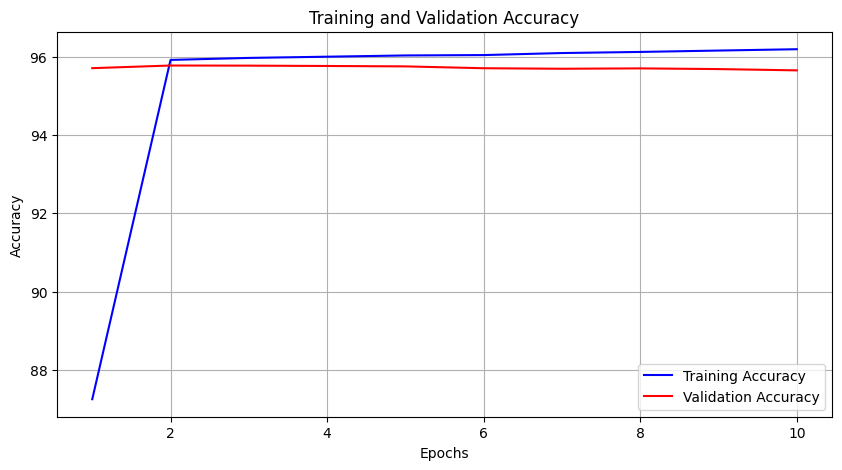

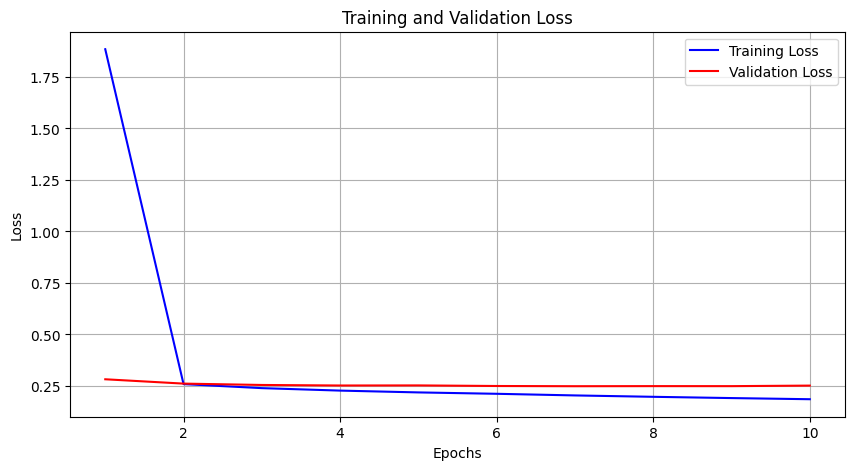

In [8]:
 # Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

try:
    # Chargement des données
    df = pd.read_csv('c4200m.tsv', sep='\t')

    # Échantillonnage
    sampled_df = sample_c4200m_data(df, sample_size=5000)

    # Entraînement avec les données échantillonnées
    model, tokenizer = train_c4200m_model(
        sampled_df,
        output_dir=' bert-c4200m-m3',
        learning_rate=1e-5,
        batch_size=16,
        epochs=10,
        max_length=512,
    )

except Exception as e:
    logging.error(f"An error occurred: {str(e)}")
    raise e